In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2


# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import datetime
import pickle


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 10)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
# import ffn


# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777

print()

Last updated: 2024-09-03T17:09:54.846077-04:00

Python implementation: CPython
Python version       : 3.8.19
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit




/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_58768/2173331131.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [2]:
import os

# Run the setup script
%run ../../config/setup_project.py

# Call the function to set up the project path
setup_project_path()

# Now you can import your modules
from src.utils import helper as h_
import src.ch_02.code_ch_02 as f_ch2
import src.ch_03.code_ch_03 as f_ch3
import src.ch_04.code_ch_04 as f_ch4
import src.ch_05.code_ch_05 as f_ch5
import src.ch_06.code_ch_06 as f_ch6


Project root added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management
Config path added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/config
Current sys.path: ['/Users/paulkelendji/miniconda3/envs/financial_math/lib/python38.zip', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/lib-dynload', '', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages/setuptools/_vendor', '/Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management', '/Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/config']
Project root added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management
Config path added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/config
Current sys.path: ['/Users/paulkelendji/miniconda3/envs/financ

In [3]:
"""Suppose that one strategy produced a sequence of bet sizes
[m1,1 , m1,2 , m1,3 ] = [.5, 1, 0], as the market price followed a sequence [p1 , p2 , p3 ] =
[1, .5, 1.25], where pt is the price at time t. The other strategy produced a sequence
[m2,1 , m2,2 , m2,3 ] = [1, .5, 0], as it was forced to reduce its bet size once the market
moved against the initial full position.
"""

pt = [1, .5, 1.25]
pt = np.array(pt)

m1 = [.5, 1, 0]
m1 = np.array(m1)

m2 = [1, .5, 0]
m2 = np.array(m2)

# diff of pt
dpt = np.diff(pt)
# add a zero at the end
dpt = np.append(dpt, 0)
dpt


array([-0.5 ,  0.75,  0.  ])

In [4]:
np.dot(m2, dpt)

-0.125

In [5]:
# SNIPPET 10.1 FROM PROBABILITIES TO BET SIZE

def getSignal(events,stepSize,prob,pred,numClasses,numThreads,**kargs):
    # get signals from predictions
    if prob.shape[0]==0:return pd.Series()
    #1) generate signals from multinomial classification (one-vs-rest, OvR)
    signal0=(prob-1./numClasses)/(prob*(1.-prob))**.5 # t-value of OvR
    signal0=pred*(2*norm.cdf(signal0)-1) # signal=side*size
    if 'side' in events:signal0*=events.loc[signal0.index,'side'] # meta-labeling
    #2) compute average signal among those concurrently open
    df0=signal0.to_frame('signal').join(events[['t1']],how='left')
    df0=avgActiveSignals(df0,numThreads)
    signal1=discreteSignal(signal0=df0,stepSize=stepSize)
    return signal1

In [12]:
# SNIPPET 10.2 BETS ARE AVERAGED AS LONG AS THEY ARE STILL ACTIVE

def avgActiveSignals(signals,numThreads):
    # compute the average signal among those active
    #1) time points where signals change (either one starts or one ends)
    tPnts=set(signals['t1'].dropna().values)
    tPnts=tPnts.union(signals.index.values)
    tPnts=list(tPnts);tPnts.sort()
    out=f_ch3.mpPandasObj(mpAvgActiveSignals,('molecule',tPnts),numThreads,signals=signals)
    return out
#———————————————————————————————————————
def mpAvgActiveSignals(signals,molecule):
    '''
    At time loc, average signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT).
    '''
    out=pd.Series()
    for loc in molecule:4
        df0=(signals.index.values<=loc)&((loc<signals['t1'])|pd.isnull(signals['t1']))
        act=signals[df0].index
        if len(act)>0:out[loc]=signals.loc[act,'signal'].mean()
        else:out[loc]=0 # no signals active at this time
    return out

In [16]:
"""
To see how the provided code works, let's create some arbitrary input data. The 
code snippet you provided calculates the average signal strength across all 
active signals at different points in time. Here's an example setup to 
demonstrate how it functions:

### 1. Create Arbitrary Input Data

Let's define some arbitrary signals where each signal has a start time, an end 
time, and a signal strength.
"""

import pandas as pd
import numpy as np

# Define arbitrary input data
data = {
    'signal': [1, -0.5, 1.5, -1, 2],
    't1': [
        pd.Timestamp('2023-09-10 12:00:00'),
        pd.Timestamp('2023-09-08 14:00:00'),
        pd.Timestamp('2023-09-15 13:00:00'),
        pd.Timestamp('2023-09-13 15:00:00'),
        pd.NaT
    ]
}
index = pd.to_datetime([
    '2023-09-01 11:00:00',
    '2023-09-05 12:30:00',
    '2023-09-07 13:30:00',
    '2023-09-12 14:00:00',
    '2023-09-20 14:30:00'
])
signals = pd.DataFrame(data, index=index)
print(signals)


                     signal                  t1
2023-09-01 11:00:00     1.0 2023-09-10 12:00:00
2023-09-05 12:30:00    -0.5 2023-09-08 14:00:00
2023-09-07 13:30:00     1.5 2023-09-15 13:00:00
2023-09-12 14:00:00    -1.0 2023-09-13 15:00:00
2023-09-20 14:30:00     2.0                 NaT


In [17]:
# Run the function on the sample data
avg_signals = avgActiveSignals(signals, numThreads=1)
print(avg_signals)

2023-09-01 11:00:00    1.000000
2023-09-05 12:30:00    0.250000
2023-09-07 13:30:00    0.666667
2023-09-08 14:00:00    1.250000
2023-09-10 12:00:00    1.500000
2023-09-12 14:00:00    0.250000
2023-09-13 15:00:00    1.500000
2023-09-15 13:00:00    0.000000
2023-09-20 14:30:00    2.000000
dtype: float64


# 10.3 Bet Sizing from predicted probabilities

/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_58768/2980055185.py:3: RuntimeWarning: divide by zero encountered in divide
  z = (px-1/2)/np.sqrt(px*(1-px))
/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_58768/2980055185.py:18: RuntimeWarning: divide by zero encountered in divide
  m_d = np.round(m/d) * d
/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_58768/2980055185.py:18: RuntimeWarning: invalid value encountered in multiply
  m_d = np.round(m/d) * d


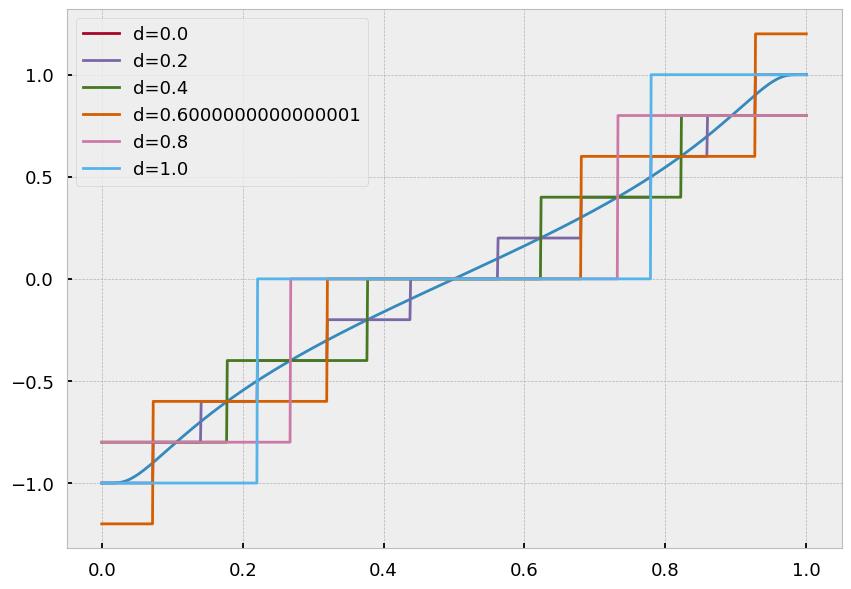

In [32]:
# z linspace from -3 to 3
px = np.linspace(0, 1, 1_000)
z = (px-1/2)/np.sqrt(px*(1-px))

# Zz as the cumulative distribution function of z
Zz = stats.norm.cdf(z)

m = 2*Zz - 1

plt.plot(px, m)

b = 0.2
ds = np.arange(0, 1, b)
ds=np.append(ds, 1) 

# discretize m with m_d = round(m/d) * d
for d in ds:
    m_d = np.round(m/d) * d
    plt.plot(px, m_d, label=f'd={d}')
    
plt.legend()


# 10.6 Dynamic Bet Sizes and Limit Prices

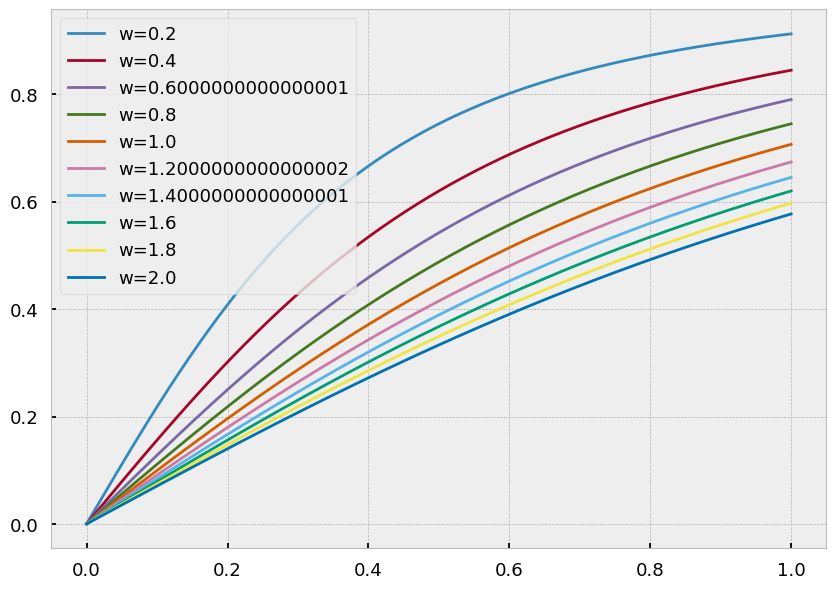

In [34]:
# z linspace from -3 to 3
x = np.linspace(0, 1, 1_000)
def m_wx(x,w):
    return x/np.sqrt(w+x**2)

b = 0.2
ws = np.arange(0+b, 2+b, b)

# discretize m with m_d = round(m/d) * d
for w in ws:
    plt.plot(x, m_wx(x,w), label=f'w={w}')
    
plt.legend()

In [125]:
def betSize(w,x):
    return x*(w+x**2)**-.5
#———————————————————————————————————————
def getTPos(w,f,mP,maxPos):
    return int(betSize(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice(f,w,m):
    return f-m*(w/(1-m**2))**.5
#———————————————————————————————————————
def limitPrice(tPos,pos,f,w,maxPos):
    sgn=(1 if tPos>=pos else -1)
    lP=0
    for j in range(abs(pos+sgn),abs(tPos+1)):
        lP+=invPrice(f,w,j/ﬂoat(maxPos))
    lP/=tPos-pos
    return lP
#———————————————————————————————————————
def getW(x,m):
    # 0<alpha<1
    x, m = x**2, m**-2
    return x*(m-1)
#———————————————————————————————————————
def main():
    pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
    w=getW(wParams['divergence'],wParams['m']) # calibrate w
    tPos=getTPos(w,f,mP,maxPos) # get tPos
    lP=limitPrice(tPos,pos,f,w,maxPos) # limit price for order
    return
#———————————————————————————————————————
if __name__=='__main__':
    main()

In [172]:
# 1) Our Meta Labelling classifier assigns a probability of 0.6, we calibrate
# The current price is pt = 100, the forecaster price is fi=115, and we have a
# maximum position size of Q=1000. 
# Our meta-labelling classifier assigns a probability of 0.6 to the forecast.
# Let's calibrate w
qt = 2 # current position
pt = 100
fi = 110
x = fi-pt # divergence
m = 0.60
Q=1_00


# Calibrate w
w = getW(x, m)
w

177.7777777777778

In [173]:
# 2) We compute the target position size
tPos = getTPos(w, fi, pt, Q)
tPos

60

In [174]:
# 3) We compute the limit price
print(f'qt={qt}, tPos={tPos}, fi={fi}, w={w}, Q={Q}')
lP = limitPrice(tPos, qt, fi, w, Q)
lP

qt=2, tPos=60, fi=110, w=177.7777777777778, Q=100


105.32280695970242

In [175]:
# 4) Price changed, and forecast changed
qt = tPos # current position
pt = 90 # current price changed
fi = 120 # forecast price changed
tPos = getTPos(w, fi, pt, Q)
tPos

91

In [176]:
print(f'qt={qt}, tPos={tPos}, fi={fi}, w={w}, Q={Q}')
lP = limitPrice(tPos, qt, fi, w, Q)
lP

qt=60, tPos=91, fi=120, w=177.7777777777778, Q=100


103.1089664571733